Statisiques descriptives sur les tmpératures relevés et predites en France métropolitaine sur l'année 2023

In [1]:
#importaiton des modules necessaires

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

Préparations des fichiers : 

In [2]:
#ouverture d'un fichiers pour l'instant pas toutes les communes car très long à obtenir mais un jour peut-être !
température = pd.read_csv('température4.csv')

In [3]:
new_name1 = {'temperature_2m_x' :  'temperature_2m', 'temperature_2m_y' : 'temperature_reelle_2m'}
température=température.rename(columns=new_name1)



In [4]:
print(température)

          Unnamed: 0.1  Unnamed: 0                       date  temperature_2m  \
0                    0           0  2023-01-01 00:00:00+00:00         10.7935   
1                    1           1  2023-01-01 01:00:00+00:00         10.5435   
2                    2           2  2023-01-01 02:00:00+00:00         10.0435   
3                    3           3  2023-01-01 03:00:00+00:00          9.2935   
4                    4           4  2023-01-01 04:00:00+00:00          9.6935   
...                ...         ...                        ...             ...   
30012135      30012135        8755  2023-12-31 19:00:00+00:00          7.2150   
30012136      30012136        8756  2023-12-31 20:00:00+00:00          6.9650   
30012137      30012137        8757  2023-12-31 21:00:00+00:00          6.6150   
30012138      30012138        8758  2023-12-31 22:00:00+00:00          6.5150   
30012139      30012139        8759  2023-12-31 23:00:00+00:00          6.5150   

           latitude  longit

In [5]:
#ajout des colonnes erreur et erreur absolue. Cette dernière est importante car le modèle se trompe presque autant en positif qu'en négatif, ainsi la moyenne de l'erreur est presque nuelle, ce qui ne nous renseigne pas beaucoup 

température["error"]=température["temperature_2m"]-température["temperature_reelle_2m"]
température["absolute_error"]=abs(température["error"])

In [6]:
température.describe()

,Unnamed: 0.1,Unnamed: 0,temperature_2m,latitude,longitude,compteur,temperature_reelle_2m,error,absolute_error
count,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07,3.001214e+07
mean,1.500607e+07,4.377007e+03,1.178816e+01,4.677136e+01,4.774628e+00,4.377007e+03,1.153931e+01,2.488530e-01,1.223032e+00
std,8.663759e+06,2.527363e+03,8.239208e+00,1.044374e+00,2.078478e+00,2.527363e+03,8.286451e+00,1.680122e+00,1.178530e+00
min,0.000000e+00,0.000000e+00,-2.455100e+01,4.512337e+01,-4.115236e-01,0.000000e+00,-2.775550e+01,-1.524900e+01,0.000000e+00
25%,7.503035e+06,2.188000e+03,5.817500e+00,4.587460e+01,4.475200e+00,2.188000e+03,5.717500e+00,-6.470001e-01,4.070020e-01
50%,1.500607e+07,4.377000e+03,1.125650e+01,4.652006e+01,5.513290e+00,4.377000e+03,1.111600e+01,2.330000e-01,8.940010e-01
75%,2.250910e+07,6.566000e+03,1.753250e+01,4.765055e+01,6.248441e+00,6.566000e+03,1.753250e+01,1.097000e+00,1.660001e+00
max,3.001214e+07,8.759000e+03,4.224550e+01,4.998521e+01,7.584537e+00,8.759000e+03,4.221800e+01,1.743900e+01,1.743900e+01


Ainsi on remarque que l'erreur de prediction de température est proche de 0 mais lorsque l'on prend l'écart de température absolue, on obtien une erreur moyenne de 1.22°, l'erreur absolue maximale de prévision fut en 2023 de 17.4° ! 

Présentation des communes de l'échantillon avec une carte : 

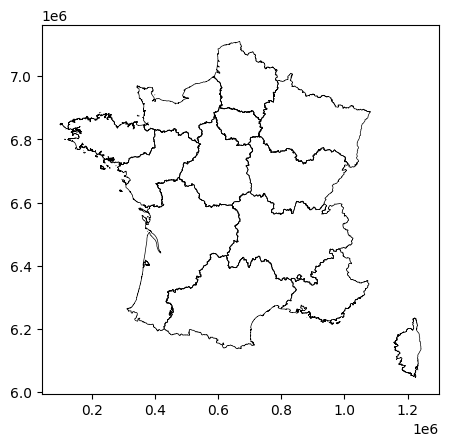

In [7]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)

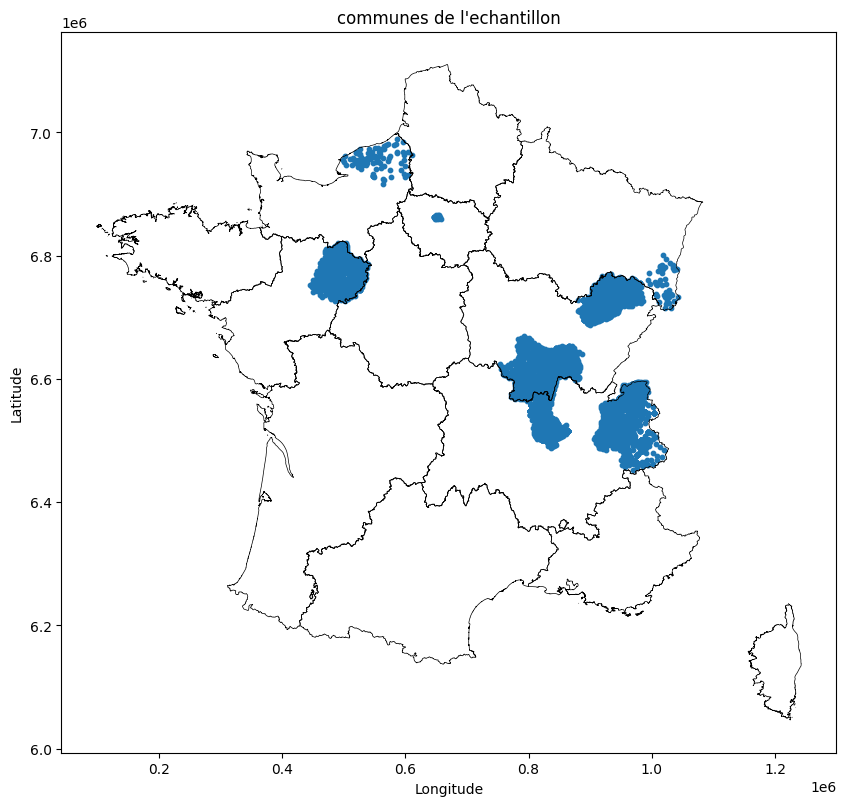

In [8]:
# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326

liste_commune= température[température["compteur"]==1]

geometry = [Point(xy) for xy in zip(liste_commune["longitude"], liste_commune["latitude"])]
geo_result = gpd.GeoDataFrame(liste_commune, geometry=geometry, crs="EPSG:4326")

# Reprojections de vos points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte avec la France et les températures sur celle-ci
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

# Afficher les points de température sur la carte
# Utiliser une couleur pour représenter la température
geo_result_2154.plot(ax=ax, markersize=10, legend=True)

# Afficher la carte avec les légendes
plt.title("communes de l'echantillon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Les communes de France sont triées par ordre alphabétique des départements l'échantillon correspond au communes 30000 à 32000 du fichier.

Etude par localisation des écarts de températures 

restriction à une seule heure de la journée et à une seule date. prenons le 1 er setptembre 2023 à 8h du matin 


In [9]:
température['date'] = pd.to_datetime(température['date']) # pour pouvoir facilement selectionner la date 

In [10]:
important_error=température[température["absolute_error"]>=10] # on regarde où et quand ont eu lieu les ecarts de prévisions importants ie supérieurs à 10°C 

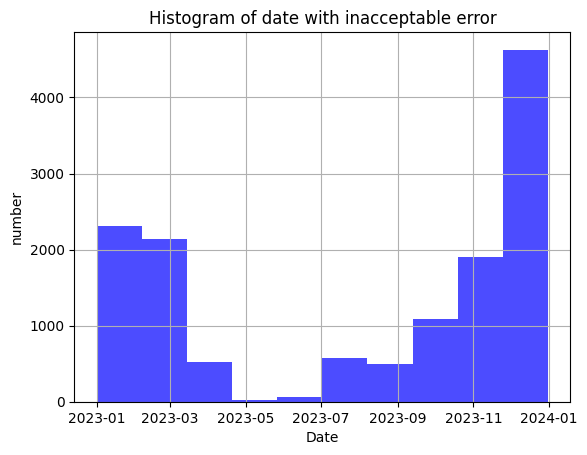

In [80]:
# Create the histogram
plt.hist(important_error["date"], alpha=0.7, color='b')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('number')
plt.title('Histogram of date with inacceptable error')
plt.grid(True)

# Show the plot
plt.show()

Sur cet échantillon de communes, le modèle semble s'être particulièrement trompé en hiver, tandis que le mois de mai semble être très prévisible

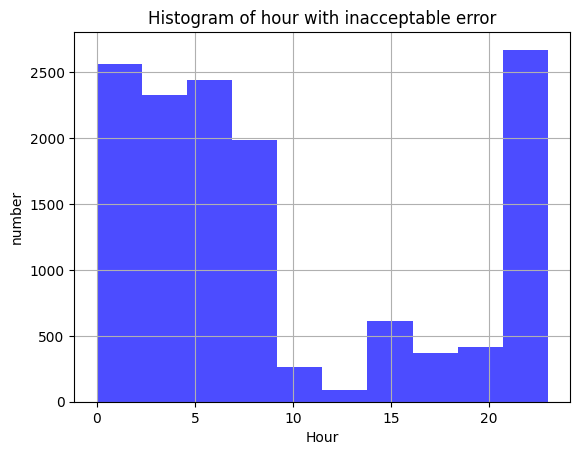

In [11]:
# Create the histogram
plt.hist(important_error["date"].dt.hour, alpha=0.7, color='b')

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('number')
plt.title('Histogram of hour with inacceptable error')
plt.grid(True)

# Show the plot
plt.show()

On remarque que le modèle semble aussi se tromper la nuit principalement 

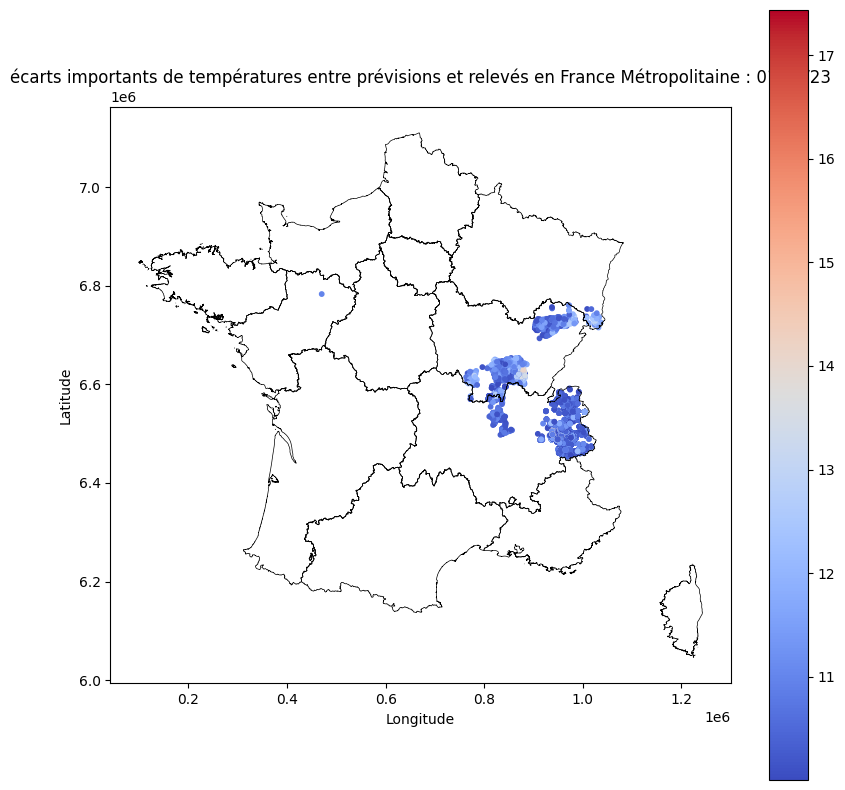

In [12]:
# Convertir le DataFrame pandas en GeoDataFrame avec la projection EPSG:4326
geometry = [Point(xy) for xy in zip(important_error["longitude"], important_error["latitude"])]
geo_result = gpd.GeoDataFrame(important_error, geometry=geometry, crs="EPSG:4326")

# Reprojections de vos points en Lambert-93 (pour correspondre à france_2154)
geo_result_2154 = geo_result.to_crs(2154)

# Afficher la carte avec la France et les températures sur celle-ci
fig, ax = plt.subplots(figsize=(10, 10))

# Afficher les frontières de la France métropolitaine
france_2154.boundary.plot(ax=ax, edgecolor="k", linewidth=0.5)

# Afficher les points de température sur la carte
# Utiliser une couleur pour représenter la température
geo_result_2154.plot(ax=ax, column="absolute_error", cmap="coolwarm", markersize=10, legend=True)

# Afficher la carte avec les légendes
plt.title("écarts importants de températures entre prévisions et relevés en France Métropolitaine : 01/09/23")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Bonne nouvelle ! a Paris (par exemple) il n'y a pas eu d'erreur trop importantes de prévision en 2023, on voit qu ces dernières s'accummule dans les régions plus montagneuses, qui sont donc plus difficilles à prédire.

Récapitulons : le modèle se trompe principalement lors des nuits d'hiver dans les zones montagneuses de l'échantillons de communes.

Etude des écarts entre relevés et prévision sur un lieu particulier au cours de l'année 2023 : on prend la première commune de la liste : 

In [16]:
Tagsdorf  = température.head(365*24-5)  # commune de Tagsdorf dans le haut Rhin 
Tagsdorf_23h = Tagsdorf[Tagsdorf["date"].dt.hour == 23]


      Unnamed: 0.1  Unnamed: 0                      date  temperature_2m  \
0                0           0 2023-01-01 00:00:00+00:00         10.7935   
1                1           1 2023-01-01 01:00:00+00:00         10.5435   
2                2           2 2023-01-01 02:00:00+00:00         10.0435   
3                3           3 2023-01-01 03:00:00+00:00          9.2935   
4                4           4 2023-01-01 04:00:00+00:00          9.6935   
...            ...         ...                       ...             ...   
8750          8750        8755 2023-12-31 19:00:00+00:00          4.7675   
8751          8751        8756 2023-12-31 20:00:00+00:00          4.7675   
8752          8752        8757 2023-12-31 21:00:00+00:00          4.9675   
8753          8753        8758 2023-12-31 22:00:00+00:00          4.6175   
8754          8754        8759 2023-12-31 23:00:00+00:00          4.7675   

       latitude  longitude  compteur  temperature_reelle_2m     error  \
0     47.62023

<function matplotlib.pyplot.show(close=None, block=None)>

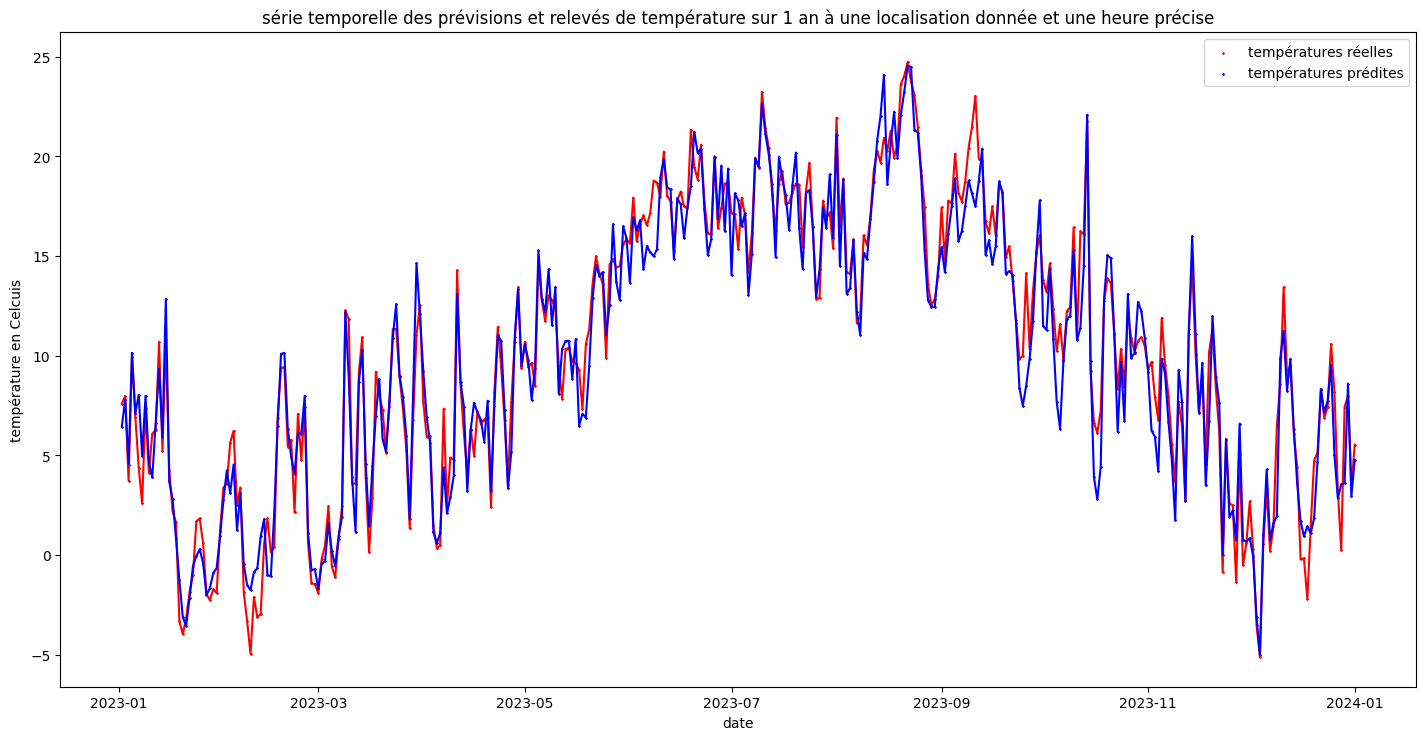

In [14]:
x = Tagsdorf_23h["date"]
temperatures_reelles = Tagsdorf_23h["temperature_reelle_2m"]
temperatures_predites = Tagsdorf_23h["temperature_2m"]

fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, temperatures_reelles, c='r', marker='X', s=0.5, label= "températures réelles") # température réelle 
plt.scatter(x, temperatures_predites, c='b', marker='X', s=0.5, label= "températures prédites")  # température prédite par le modèle 
plt.legend()
# Set labels
plt.xlabel('date')
plt.ylabel('température en Celcuis')
plt.title("série temporelle des prévisions et relevés de température sur 1 an à une localisation donnée et une heure précise")

plt.plot(x, temperatures_reelles, color='r')
plt.plot(x, temperatures_predites, color='b')
 
plt.show


On remarque que les deux courbes se superposent globaement bien, nous arrivons bien à suivre la tendance globale. Traçons désormais les écarts absolus 

<function matplotlib.pyplot.show(close=None, block=None)>

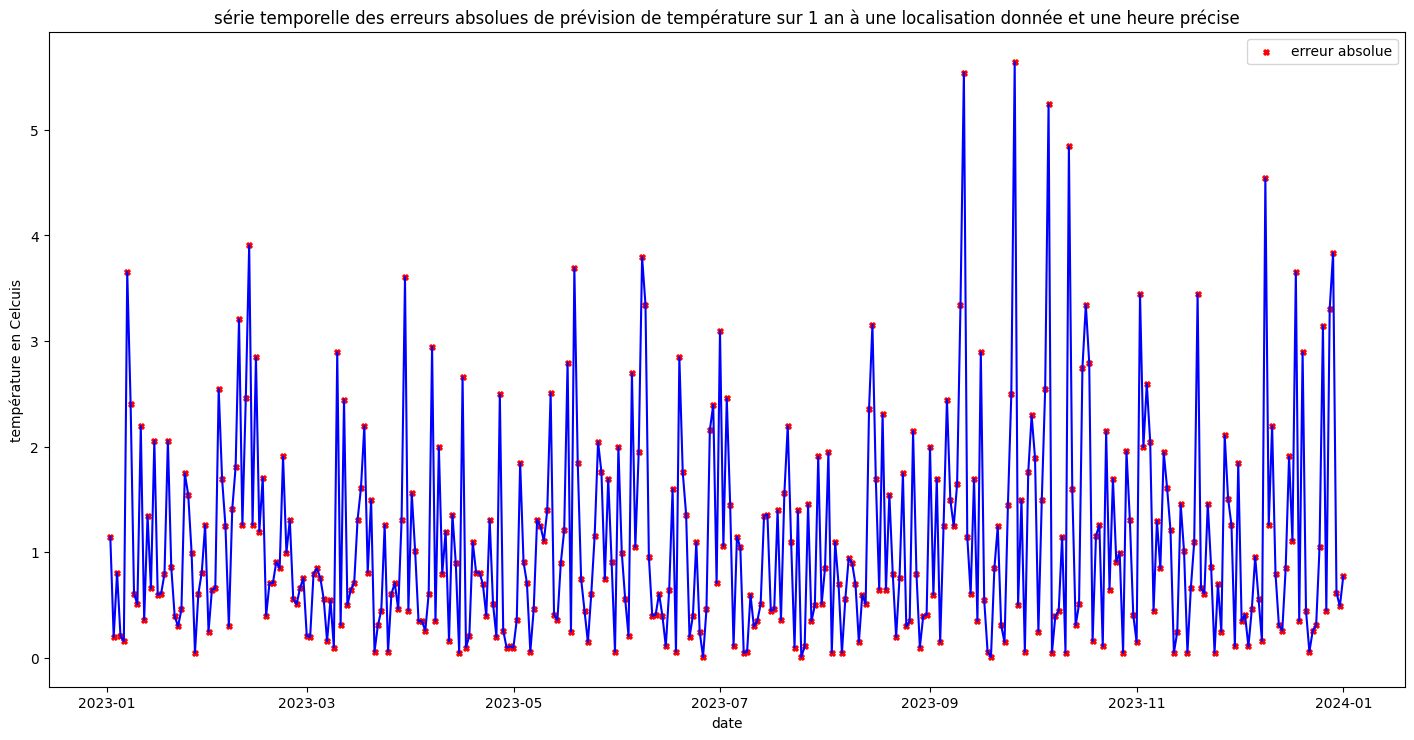

In [15]:
x = Tagsdorf_23h["date"]
y1 = Tagsdorf_23h["absolute_error"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "erreur absolue") # température réelle 
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('température en Celcuis')
plt.title("série temporelle des erreurs absolues de prévision de température sur 1 an à une localisation donnée et une heure précise")

plt.plot(x, y1, color='b')


plt.show

Essayons de voir si la présence ou non d'autres facteurs météorologique pourraient expliquer ces écarts. 

In [18]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 47.620239,
	"longitude": 7.300485,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "precipitation", "snow_depth", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]


# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(2).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

Tagsdorf_past_data = pd.DataFrame(data = hourly_data)
print(Tagsdorf_past_data)

                          date  temperature_2m  precipitation  snow_depth  \
0    2023-01-01 00:00:00+00:00        8.688001            0.0         0.0   
1    2023-01-01 01:00:00+00:00        9.338000            0.0         0.0   
2    2023-01-01 02:00:00+00:00        9.088000            0.0         0.0   
3    2023-01-01 03:00:00+00:00       11.138000            0.0         0.0   
4    2023-01-01 04:00:00+00:00       11.988000            0.0         0.0   
...                        ...             ...            ...         ...   
8755 2023-12-31 19:00:00+00:00        5.288000            0.0         0.0   
8756 2023-12-31 20:00:00+00:00        5.138000            0.0         0.0   
8757 2023-12-31 21:00:00+00:00        5.488000            0.0         0.0   
8758 2023-12-31 22:00:00+00:00        5.488000            0.0         0.0   
8759 2023-12-31 23:00:00+00:00        5.538000            0.0         0.0   

      surface_pressure  cloud_cover  cloud_cover_low  cloud_cover_mid  \
0 

In [19]:
Tagsdorf_past_data['date'] = pd.to_datetime(Tagsdorf_past_data['date']) # pour pouvoir facilement selectionner la date 

In [21]:
Tagsdorf_past_data_23h= Tagsdorf_past_data[Tagsdorf_past_data["date"].dt.hour==23]

<function matplotlib.pyplot.show(close=None, block=None)>

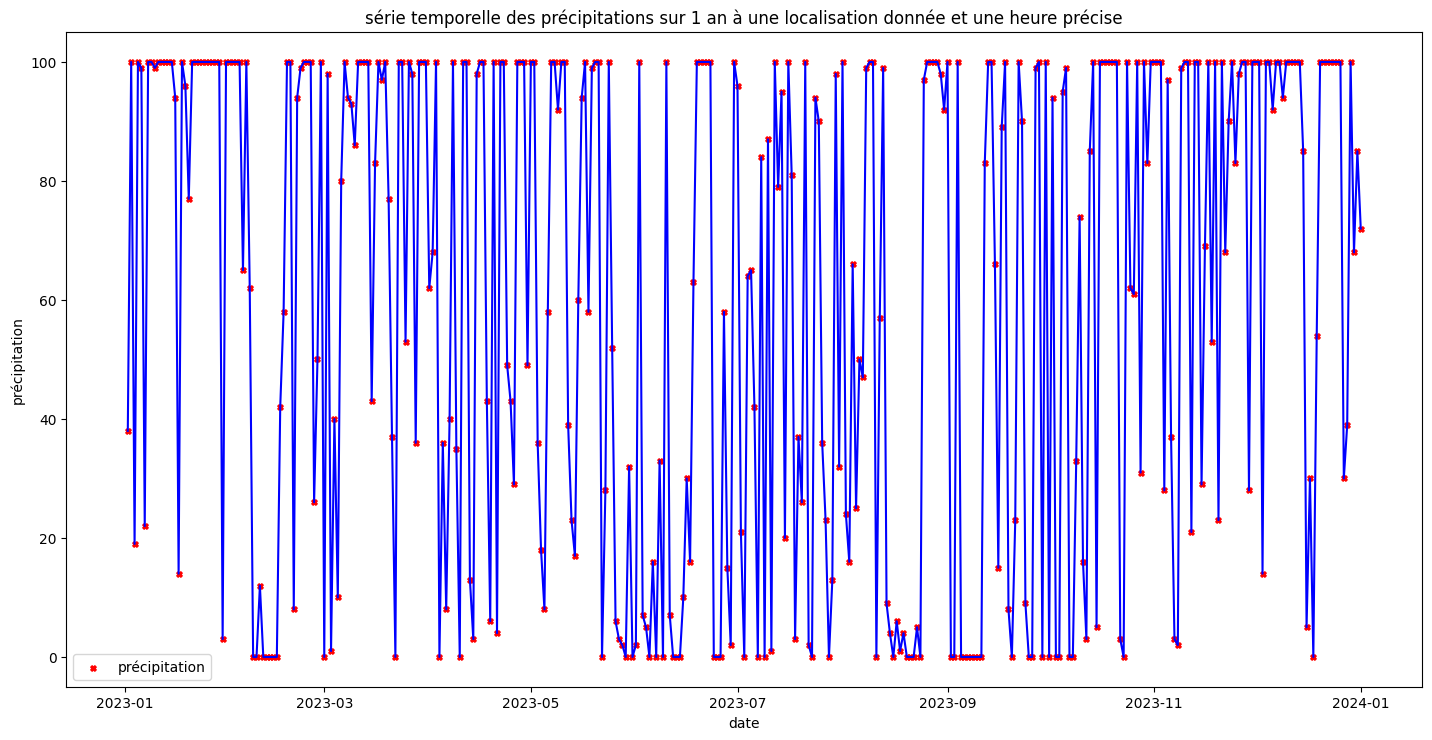

In [25]:
x = Tagsdorf_past_data_23h["date"]
y1 = Tagsdorf_past_data_23h["cloud_cover"]


fig = plt.figure(figsize=(17.5,8.5))

# Scatter plot the points
plt.scatter(x, y1, c='r', marker='X', s=15, label= "précipitation") # température réelle 
plt.legend()

# Set labels
plt.xlabel('date')
plt.ylabel('précipitation')
plt.title("série temporelle des précipitations sur 1 an à une localisation donnée et une heure précise")

plt.plot(x, y1, color='b')


plt.show

In [26]:
from scipy.stats import pearsonr

In [34]:
x = Tagsdorf_23h["absolute_error"]
surface_pressure = Tagsdorf_past_data_23h["surface_pressure"]

corr_coeff, p_value = pearsonr(x, surface_pressure)
print(f"Pearson Correlation Coefficient: {corr_coeff}")
print(f"p-value: {p_value}")



Pearson Correlation Coefficient: 0.10149260646648883
p-value: 0.052700389624296344


In [32]:
precipitation = Tagsdorf_past_data_23h["precipitation"]

corr_coeff, p_value = pearsonr(x, precipitation)
print(f"Pearson Correlation Coefficient: {corr_coeff}")
print(f"p-value: {p_value}")

Pearson Correlation Coefficient: -0.10025935503496591
p-value: 0.0556576608562833


In [37]:
snow_depth = Tagsdorf_past_data_23h["snow_depth"]

corr_coeff, p_value = pearsonr(x, snow_depth)
print(f"Pearson Correlation Coefficient: {corr_coeff}")
print(f"p-value: {p_value}")

Pearson Correlation Coefficient: -0.07766295266249268
p-value: 0.13863409086475148


In [38]:
cloud_cover = Tagsdorf_past_data_23h["cloud_cover"]

corr_coeff, p_value = pearsonr(x, cloud_cover)
print(f"Pearson Correlation Coefficient: {corr_coeff}")
print(f"p-value: {p_value}")

Pearson Correlation Coefficient: -0.08711089998615448
p-value: 0.09657233476744281


Ansi les autres variables météorologique présentent ici (présence et intensité des précipitation, epaisseur de neige, ou la couvreture nuageuse) ne semble pas être correlés à l'écart entre les températures prédites et les températures réelles. 